In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import mode
from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis
from sklearn.decomposition import PCA
from sklearn import preprocessing
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
import sklearn.discriminant_analysis as skda
import sklearn.linear_model as sk
import sklearn.neighbors as knn
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import Lasso as Lasso_Reg
from statsmodels.regression.linear_model import OLS
from sklearn.tree import DecisionTreeClassifier as DecisionTree
import sklearn.preprocessing as Preprocessing
from sklearn.metrics import r2_score

In [2]:
filled = pd.read_csv('train_filled.csv')
store = pd.read_csv('store.csv')
train = filled

##  Milestone 4

### Part 1: Exploratory Data Analysis

For this part, having filled in the missing data for stores that underwent a 6-month refurbishment with mean values from averaging across all the stores that stayed open, we took the more complete data and took a look at how it is distributed, and what points of interest there might be.

In [3]:
store.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

In [4]:
filled.head()

Store  DayOfWeek        Date    Sales  Customers  Open  Promo  \
0      1          5  2015-07-31   5263.0      555.0     1      1   
1      2          5  2015-07-31   6064.0      625.0     1      1   
2      3          5  2015-07-31   8314.0      821.0     1      1   
3      4          5  2015-07-31  13995.0     1498.0     1      1   
4      5          5  2015-07-31   4822.0      559.0     1      1   

   StateHoliday  SchoolHoliday  
0             0              1  
1             0              1  
2             0              1  
3             0              1  
4             0              1

As can be seen above, there are many features associated with the data. We zeroed in on several relationships that were promising in terms of revealing relationships in the data.

The first one we can look at is the relation between Sales and the Day of the Week:

In [5]:
sales = filled['Sales'].values
customers = filled['Customers'].values

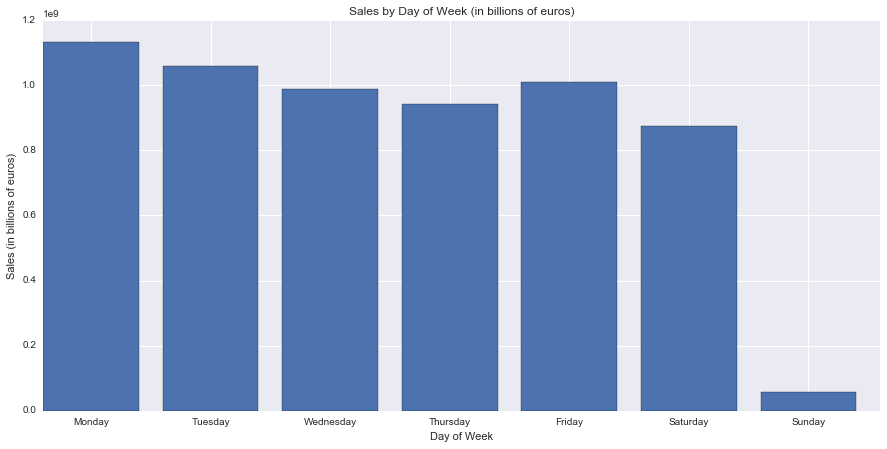

In [6]:
sales_by_day_of_week = filled.groupby('DayOfWeek')['Sales'].sum()
days_of_week = sorted(filled.groupby(['DayOfWeek']).groups.keys())
x = np.arange(len(days_of_week))
width = .4
day_ticks = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(15,7))
plt.bar(x, sales_by_day_of_week)
plt.xticks(x + width, day_ticks)
plt.title('Sales by Day of Week (in billions of euros)')
plt.xlabel('Day of Week')
plt.ylabel('Sales (in billions of euros)')
plt.show()

It seems that the highest number of sales occurs on Monday, after which it tapers off until Friday. Also, Sunday sees very few sales, which may be due to stores closing - let us see if that guess is borne out in the data:

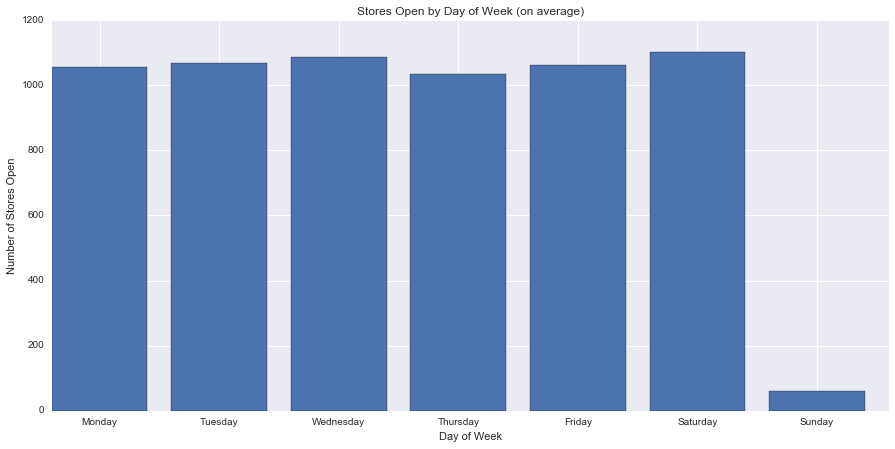

In [7]:
dates = sorted(filled.groupby(['Date']).groups.keys())
num_each_day = len(dates)/7.
open_by_day_of_week = filled.groupby('DayOfWeek')['Open'].sum()/num_each_day
days_of_week = sorted(filled.groupby(['DayOfWeek']).groups.keys())
x = np.arange(len(days_of_week))
width = .4
day_ticks = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(15,7))
plt.bar(x, open_by_day_of_week)
plt.xticks(x + width, day_ticks)
plt.title('Stores Open by Day of Week (on average)')
plt.xlabel('Day of Week')
plt.ylabel('Number of Stores Open')
plt.show()

And it is. The vast majority of stores are closed on Sunday, which means a dramatic reduction in sales numbers.

The next thing we will look at is the relationship between Sales and distance from the competition.

First, we can take a look at how far away competition tends to be:

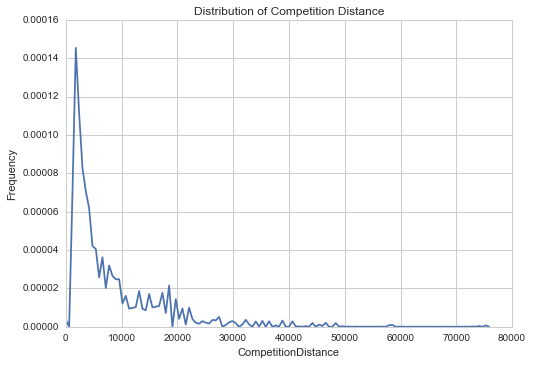

In [8]:
data = store['CompetitionDistance'].values
sns.set_style('whitegrid')
plt.title('Distribution of Competition Distance')
plt.xlabel('CompetitionDistance')
plt.ylabel('Frequency')
sns.kdeplot(np.array(data), bw=0)

Next, we look at Sales vs. CompetitionDistance:

In [9]:
store_compdist = {}
stores = store['Store'].values
compdist = store['CompetitionDistance'].values
for i in xrange(len(stores)):
    store_compdist[stores[i]] = compdist[i]

In [10]:
stores_train = filled['Store'].values
compdist_train = []
for s in stores_train:
    compdist_train.append(store_compdist[s])

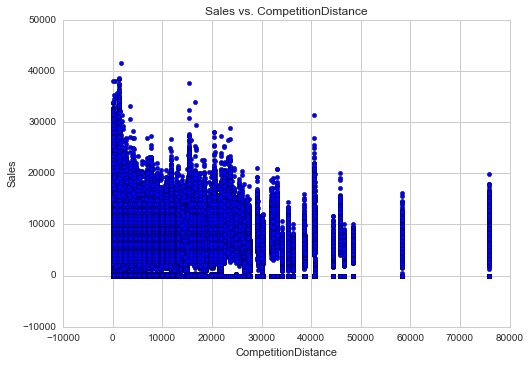

In [11]:
plt.xlabel('CompetitionDistance')
plt.ylabel('Sales')
plt.title('Sales vs. CompetitionDistance')
plt.scatter(compdist_train, sales)

It seems interestingly that closer competition is correlated with higher sales figures overall. We suspect that this is because good locations tend to attract both lots of customers, and more competition who are also aware that the location is good. 

We now look at Sales compared to the number of customers:

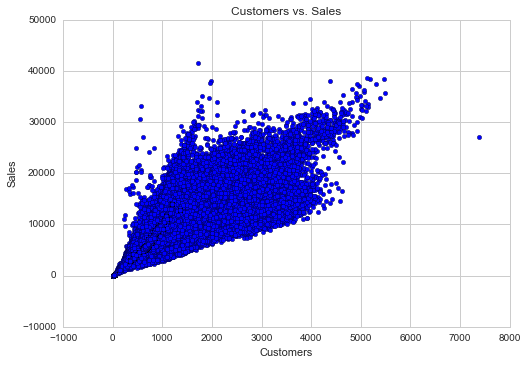

In [12]:
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.title('Customers vs. Sales')
plt.scatter(customers, sales)

There seem to be a few prominent lines in the graph, which suggests that we can do more to explore the data and segment it. We now segment the data by the type of store - the types are a, b, c, and d.

In [13]:
store_type_data = {'a':{}, 'b':{}, 'c':{}, 'd':{}}
for store_type in store_type_data:
    matching_stores = store[store['StoreType'] == store_type]['Store'].values
    store_type_data[store_type]['stores'] = matching_stores
    
    sales = filled[filled['Store'].isin(matching_stores)]['Sales']
    customers = filled[filled['Store'].isin(matching_stores)]['Customers']
    store_type_data[store_type]['sales'] = sales
    store_type_data[store_type]['customers'] = customers

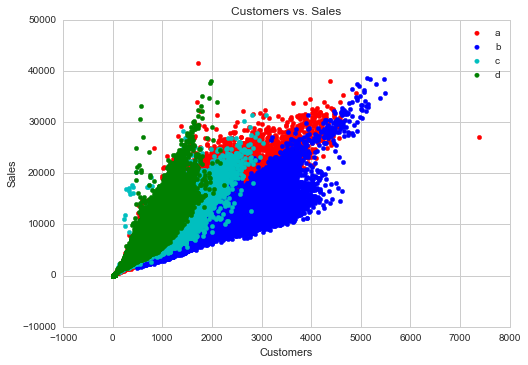

In [14]:
store_type_data['a']['color'] = 'r'
store_type_data['b']['color'] = 'b'
store_type_data['c']['color'] = 'c'
store_type_data['d']['color'] = 'g'
scatters = []

for store_type in ['a', 'b', 'c', 'd']:
    sales = store_type_data[store_type]['sales']
    customers = store_type_data[store_type]['customers']
    color = store_type_data[store_type]['color']
    scatters.append(plt.scatter(customers, sales, color=color))

plt.xlabel('Customers')
plt.ylabel('Sales')
plt.title('Customers vs. Sales')
plt.legend(scatters, ['a', 'b', 'c', 'd'])
plt.show()

From segmenting the data, it looks like stores of type 'd' (green) tend to have fewer customers but higher sales per customer, while stores of type 'b' (dark blue) tend to have more customers but lower sales per customer. This means that stores of type 'd' need fewer customers to make the same amount of sales in euros as stores of type 'b'. Stores of types 'a' and 'c' run through the middle of these two other types.

### Part 2: Baseline Model Selection

Through our exploratory data analysis, we were able to make sense of the stores data and were able to hypothesize which models would best work for predicting customers and sales. We will now proceed to look at three models in particular: Linear Regression, Ridge Regression, and Decision Trees.

In [15]:
"""Rearranging/Reorganizing the data for building the models"""
y_customers = train['Customers']
y_sales = train['Sales']
del train['Customers']
del train['Sales']
y = pd.DataFrame()
y['Customers'] = y_customers.values
y['Sales'] = y_sales.values
date_vals = train['Date'].values
for i in range(len(date_vals)):
    date_vals[i] = date_vals[i][0:4] + date_vals[i][5:7] + date_vals[i][8::]
del train['Date']
train['Date'] = date_vals

#### Linear Regression
We will now proceed to linear regression modeling, which involves a two-step process: first, we must predict the number of customers each store will receive, and then proceed to predicting sales

In [16]:
"""Predicting Customers"""
x_train, x_test, y_train, y_test = train_test_split(train, y_customers, test_size = 0.3)
lin_reg = Lin_Reg()
lin_reg.fit(x_train, y_train)
y_pred = lin_reg.predict(x_test)
score = r2_score(y_test, y_pred)
print('R2 Score from predicting customers = %f' %(score))

R2 Score from predicting customers = 0.379677


Now that we have a model for predicting customers, we can proceed to predicting sales

In [17]:
#Appending the predicted customers to the dataframe
full_pred = lin_reg.predict(train)
train_predicted = train
train_predicted['Customers'] = full_pred

#Building a model for predicting sales
x_train, x_test, y_train, y_test = train_test_split(train_predicted, y_sales, test_size = 0.3)
lin_reg = Lin_Reg()
lin_reg.fit(x_train, y_train)
sales_pred = lin_reg.predict(x_test)
score = r2_score(y_test, sales_pred)
print('R2 Score from predicting sales = %f' %(score))

#Appending the predicted customers to the dataframe
full_pred = lin_reg.predict(train_predicted)
train_predicted['Sales'] = full_pred

R2 Score from predicting sales = 0.503882


#### Linear Regression
We will now proceed to Ridge Regression modeling. We must not only follow a procedure for predicting customers then sales, but also must identify which regularization constant best works for the data

In [18]:
"""Predicting Customers"""
x_train, x_test, y_train, y_test = train_test_split(train, y_customers, test_size = 0.3)
scores = []
for val in [10e-7, 10e-6, 10e-5, 10e-4, 10e-3,10e-2, 10e-1, 10, 100, 1000, 10000]:
    reg = Ridge_Reg(alpha = val)
    reg.fit(x_train, y_train)
    scores.append(r2_score(reg.predict(x_test), y_test))
print("R2 Scores for different values of the regularization constant:")
print(scores)

R2 Scores for different values of the regularization constant:
[-0.63089631430831483, -0.63089631430831794, -0.63089631430834947, -0.63089631430867277, -0.63089631431189552, -0.6308963143441122, -0.63089631466628493, -0.63089631788674794, -0.6308963499669813, -0.63089665884780999, -0.630898917794531]


In [19]:
"""Predicting Sales"""
train['Costumers'] = y_customers.values
x_train, x_test, y_train, y_test = train_test_split(train, y_sales, test_size = 0.3)
scores = []
for val in [10e-7, 10e-6, 10e-5, 10e-4, 10e-3,10e-2, 10e-1, 10, 100, 1000, 10000]:
    reg = Ridge_Reg(alpha = val)
    reg.fit(x_train, y_train)
    scores.append(r2_score(reg.predict(x_test), y_test))
print("R2 Scores for different values of the regularization constant:")
print(scores)


R2 Scores for different values of the regularization constant:
[0.82384773322449745, 0.82384773322449789, 0.82384773322449967, 0.82384773322451899, 0.82384773322471205, 0.82384773322664351, 0.82384773324595628, 0.82384773343888895, 0.82384773534879752, 0.82384775262786691, 0.82384781949473174]


In [22]:
print np.asarray(y_train)

[ 723.  858.  567. ...,    0.  639.  409.]


In [28]:
print x_train

         Store  DayOfWeek  Open  Promo  StateHoliday  SchoolHoliday      Date  \
286675     886          6     1      0             0              0  20141108   
609850     731          3     0      0             1              1  20140101   
1027636    306          2     0      0             0              0  20141104   
449251     692          7     0      0             0              0  20140525   
76369      550          7     0      0             0              0  20150524   
319543    1054          6     1      0             0              0  20141004   
605158     499          7     0      0             0              0  20140105   
116866     907          6     1      0             0              0  20150418   
868249     450          2     1      1             0              0  20130514   
483688     564          4     1      0             0              1  20140424   
336411    1098          2     1      1             0              0  20140916   
312072    1064          7   

In [25]:
type(np.asarray(y_train)[0])

numpy.float64

In [26]:
[i for i in np.asarray(y_train) if type(i) is not np.float64]

[]

In [35]:
print np.asarray(y_train)

[  411.     0.  1735. ...,   936.     0.   764.]


In [39]:
print np.asarray([1.,2.,3.])

[ 1.  2.  3.]


#### Decision Trees
We will now proceed to Decision Tree Classification

In [74]:
#DOESN'T WORK - because Decision Trees classify stuff into categories, they don't predict specific sales numbers

"""Predicting Customers"""
x_train, x_test, y_train, y_test = train_test_split(train.as_matrix(), y_customers, test_size = 0.3)
lin_reg = DecisionTree(max_depth=20)
print y_train.tolist()
print y_train.dtype
# print np.asarray(y_train[:100])
print [448.,1197.,616.]
# lin_reg.fit(x_train[:10], np.asarray(y_train)[:10])
# lin_reg.fit(x_train[:15], y_train.tolist()[:15])
lin_reg.fit(x_train, y_train.tolist())

# lin_reg.fit(x_train[:3], np.asarray([448.,1197.,616.]))
y_pred = lin_reg.predict(x_test)
score = r2_score(y_test, y_pred)
print('R2 Score from predicting customers = %f' %(score))

[719.0, 641.0, 318.0, 779.0, 777.0, 936.0, 852.0, 292.0, 874.0, 335.0, 571.0, 1014.0, 459.0, 680.0, 727.0, 767.0, 768.0, 1415.0, 497.0, 806.0, 0.0, 1200.0, 763.0, 0.0, 1098.0, 3118.0, 1024.0, 699.0, 0.0, 1083.0, 531.0, 574.0, 492.0, 910.0, 625.0, 0.0, 1041.0, 853.0, 461.0, 547.0, 0.0, 0.0, 871.0, 1686.0, 743.0, 604.0, 616.0, 0.0, 436.0, 618.0, 0.0, 0.0, 1283.0, 1258.0, 337.0, 341.0, 817.0, 757.0, 482.0, 1098.0, 1311.0, 416.0, 998.0, 1000.0, 719.0, 954.0, 0.0, 1073.0, 0.0, 646.0, 707.0, 1201.0, 475.0, 1122.0, 476.0, 900.0, 489.0, 478.0, 342.0, 535.0, 925.0, 1043.0, 998.0, 893.0, 716.0, 574.0, 613.0, 0.0, 582.0, 1138.0, 0.0, 544.0, 668.0, 550.0, 419.0, 1093.0, 687.52556053800004, 552.0, 678.0, 778.0, 1472.0, 784.0, 498.0, 1691.0, 645.0, 542.0, 426.0, 840.0, 562.0, 699.0, 453.0, 763.0, 558.0, 1116.0, 611.06098654699997, 573.0, 1344.0, 0.0, 759.0, 0.0, 409.0, 679.0, 752.0, 1026.0, 722.0, 405.0, 796.0, 634.0, 1011.0, 604.0, 820.0, 689.0, 706.63408071699996, 0.0, 0.0, 1547.0, 877.0, 1291.0, 

ValueError: Unknown label type: array([[ 719.],
       [ 641.],
       [ 318.],
       ..., 
       [   0.],
       [ 592.],
       [   0.]])

In [ ]:
print x_train

In [ ]:
print np.zeros(len(x_train))

In [ ]:
train

PARAGRAPH DRAFT

We looked at three different models: Ridge Regression, Linear Regression, and Decision Trees. Linear Regression performed moderately well, with an R2 Score of ~0.35 when predicting the number of customers, and a score of ~0.50 when predicting the sales. Meanwhile, Ridge Regression achieved an R2 Score of ~ -0.64 for customers and ~0.82 for sales. The disparity in these two scores is a bit alamaring, and one would absolutely need to further investigate the reasons for such disparity, and what sort of prediction errors might have caused it. 